In [1]:
from collections import defaultdict
import requests
from time import sleep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
from datetime import datetime, timedelta, time
from urllib.error import HTTPError
import statistics

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#
cur_working_directiory = os.getcwd()
# Change 
os.chdir("../../Data/")


CSVfiles = []
for file in os.listdir("./"):
  if file.endswith(".csv"):
    CSVfiles.append(file)
print(CSVfiles)


unixTimeConverter = lambda x : (datetime.fromtimestamp(x)).strftime('%Y-%m-%d %H:%M:%S')
unixTimeConverterNoDateJustTime = lambda x: (datetime.fromtimestamp(x) - timedelta(hours=4)).time()


allDfs = []


for x in CSVfiles:

  dfTemp = pd.read_csv(x)
  dfTemp['estTime']  = dfTemp['time'].apply(unixTimeConverter)
  dfTemp['timeOnly'] = dfTemp['time'].apply(unixTimeConverterNoDateJustTime)

  dfTemp['candleHeight']  = dfTemp.apply( lambda row:    max(row['open'],  row['close']) - min(row['open'],  row['close']), axis = 1 )
  allDfs.append(dfTemp)

df = allDfs[1]
#This is for generating if profit
for i in range(1, 15):
  df['P/L' +str(i) +'Short_']  = ( df['close'] - df['close'].shift(-i) )
  df['P/L' +str(i) +'Long_']  =  (  df['close'].shift(-i) - df['close']     )
  df['P/L' +str(i) +'Short']  = ( df['close'] - df['close'].shift(i) )
  df['P/L' +str(i) +'Long']  =  (  df['close'].shift(i) - df['close']     )

df = df.dropna()


os.chdir(cur_working_directiory)

df.head()

['OANDA EURUSD, 5(2).csv', 'OANDA EURUSD, 60(3).csv']


,time,open,high,low,close,Volume,Volume MA,estTime,timeOnly,candleHeight,...,P/L12Short,P/L12Long,P/L13Short_,P/L13Long_,P/L13Short,P/L13Long,P/L14Short_,P/L14Long_,P/L14Short,P/L14Long
19,1577984400,1.11662,1.11720,1.11636,1.11700,2456,2274.15,2020-01-02 12:00:00,08:00:00,0.00038,...,-0.00344,0.00344,0.00008,-0.00008,-0.00313,0.00313,0.00166,-0.00166,-0.00434,0.00434
20,1577988000,1.11700,1.11724,1.11636,1.11704,2169,2379.35,2020-01-02 13:00:00,09:00:00,0.00004,...,-0.00374,0.00374,0.00170,-0.00170,-0.00340,0.00340,0.00192,-0.00192,-0.00309,0.00309
21,1577991600,1.11704,1.11705,1.11644,1.11664,1748,2443.65,2020-01-02 14:00:00,10:00:00,0.00040,...,-0.00435,0.00435,0.00152,-0.00152,-0.00414,0.00414,0.00263,-0.00263,-0.00380,0.00380
22,1577995200,1.11664,1.11716,1.11659,1.11692,1412,2491.70,2020-01-02 15:00:00,11:00:00,0.00028,...,-0.00429,0.00429,0.00291,-0.00291,-0.00407,0.00407,0.00331,-0.00331,-0.00386,0.00386
23,1577998800,1.11692,1.11736,1.11691,1.11728,548,2473.50,2020-01-02 16:00:00,12:00:00,0.00036,...,-0.00304,0.00304,0.00367,-0.00367,-0.00393,0.00393,0.00428,-0.00428,-0.00371,0.00371


In [2]:
d_counts_average_vol            = defaultdict(list)
d_counts_average_highLow_diff   = defaultdict(list)


closeOpenDeltaList = []
closeOpenDeltaList_ = []
openLowDeltaList = []
highLowDeltaList = []

for index, row in df.iterrows():
  closeOpenDeltaList.append(abs(row['close'] - row['open']))
  closeOpenDeltaList_.append(row['close'] - row['open'])
  openLowDeltaList.append(abs(row['open'] - row['low']))
  highLowDeltaList.append(row['high'] - row['low'])


df1 = pd.DataFrame({'closeOpenDelta': closeOpenDeltaList, 'CloseOpenDelta_': closeOpenDeltaList_, 'openLowDelta': openLowDeltaList, 'highLowDelta': highLowDeltaList})

# df2 = pd.concat([df, df1])

df2 = pd.concat([df.reset_index(drop=True), df1.reset_index(drop=True)], axis=1)
print("mnath should add up")
print(df.shape)
print(df1.shape)
print(df2.shape)
df= df2

for index, row in df.iterrows():
  #put volumes in d
  time_  = str(row['timeOnly'])
  volume = row['Volume']
  d_counts_average_vol[str(time_)].append(volume)


  #Collecting, using a dictionary of lists to collect the price deltas for each time
  price_delta = row['closeOpenDelta']
  d_counts_average_highLow_diff[str(time_)].append(price_delta)

df.head()

###############################################
##THIS use to be seperate cells, but now I just combined them
##
################################################
import statistics

std_values_with_time_as_keys = {}
mean_values_with_time_as_keys = {}

#for volume
std_values_with_time_as_keys_volume = {}
mean_values_with_time_as_keys_volume = {}

for k , v in d_counts_average_highLow_diff.items():

  # Calculate mean and standard deviation of the sample for price delta
  mean = statistics.mean(v)
  std_dev = statistics.stdev(v)
  std_values_with_time_as_keys[k] = std_dev
  mean_values_with_time_as_keys[k] = mean

for k , v in d_counts_average_vol.items():
  # Calculate mean and standard deviation of the sample of volume
  mean__ = statistics.mean(v)
  std_dev__ = statistics.stdev(v)
  std_values_with_time_as_keys_volume[k] = std_dev__
  mean_values_with_time_as_keys_volume[k] = mean__


z_score_list = []
z_score_volume_list = []

for index, row in df.iterrows():
  time_  = str(row['timeOnly'])
  mean_ = mean_values_with_time_as_keys[time_]
  std_ = std_values_with_time_as_keys[time_]

  cur_val = row['closeOpenDelta']
  z_score_list.append(( cur_val - mean)/ std_)
  # row['z-score'] = (row['closeOpenDelta'] - mean)/ std_
  
  mean_ = mean_values_with_time_as_keys_volume[time_]
  std_ = std_values_with_time_as_keys_volume[time_]
  df.loc[index, 'z-score-volume'] = (row['Volume'] - mean)/ std_

df['z-score']= z_score_list 
# df['z-score-volume']= 


df.head(1)


mnath should add up
(22049, 66)
(22049, 4)
(22049, 70)


,time,open,high,low,close,Volume,Volume MA,estTime,timeOnly,candleHeight,...,P/L14Short_,P/L14Long_,P/L14Short,P/L14Long,closeOpenDelta,CloseOpenDelta_,openLowDelta,highLowDelta,z-score-volume,z-score
0,1577984400,1.11662,1.1172,1.11636,1.117,2456,2274.15,2020-01-02 12:00:00,08:00:00,0.00038,...,0.00166,-0.00166,-0.00434,0.00434,0.00038,0.00038,0.00026,0.00084,0.775458,-0.821528


In [3]:
""" 
This is a split test, curious to see if having a 
low openLowDelta, along with a 4+ z-score, will
increase a higher profitablity rate.
"""

totalProfShort = defaultdict(float)
totalProfLong  = defaultdict(float)
totalPro       = defaultdict(float)

#Note this is actually shorting, I am doing the opposite of the 
#Large directional move, hence mean reversion
totalProfLongList = defaultdict(list)
#Comparing this 
#to see if only buy when the open and low are close together
totalProfLongListWithLowOpenLowDelata = defaultdict(list)
totalProfLongWithLowOpenLowDelta      = defaultdict(float)
#
#to see if only buy when the open and low are FAR away
totalProfLongListWithHighOpenLowDelata = defaultdict(list)
totalProfLongWithHighOpenLowDelta      = defaultdict(float)
#
#volume filter
totalProfLongListWithHighVolume = defaultdict(list)
totalProfLongWithHighVolume      = defaultdict(float)
totalProfLongListWithLowVolume = defaultdict(list)
totalProfLongWithLowVolume      = defaultdict(float)
#to see if only buy when the open and low are close together
totalProfLongListWithLowOpenLowDelata_filter_big_moves = defaultdict(list)
totalProfLongWithLowOpenLowDelta_filter_big_moves      = defaultdict(float)
# filter for only the largest moves
totalProfLongListWithLowOpenLowDelata_filter_most_moves = defaultdict(list)
totalProfLongWithLowOpenLowDelta_filter_most_moves      = defaultdict(float)


# With Stop Losses
totalProfLongListStopLoss = defaultdict(list)
totalProfLongStopLoss  = defaultdict(float)



# allBigSDMoves
for index, row in df.iterrows():
  if row['z-score'] >= 3:
    if row['CloseOpenDelta_'] > 0:
      for i in range(1,15):
        lookup = 'P/L' + str(i) +'Short'
        totalProfLong[lookup] +=row[lookup]
        totalProfLongList[lookup].append(row[lookup])
        #print(row['CloseOpenDelta_'])
        if row['openLowDelta'] <= 0.00006:
          totalProfLongWithLowOpenLowDelta[lookup] +=row[lookup]
          totalProfLongListWithLowOpenLowDelata[lookup].append(row[lookup])
        if row['openLowDelta'] > 0.00006:
          totalProfLongWithHighOpenLowDelta[lookup] +=row[lookup]
          totalProfLongListWithHighOpenLowDelata[lookup].append(row[lookup])
        if row['z-score-volume'] >= 2:
          totalProfLongWithHighVolume[lookup] +=row[lookup]
          totalProfLongListWithHighVolume[lookup].append(row[lookup])
        if row['z-score'] <= 4:
          totalProfLongListWithLowOpenLowDelata_filter_big_moves[lookup].append(row[lookup])
          totalProfLongWithLowOpenLowDelta_filter_big_moves[lookup] +=row[lookup]
        if row['z-score'] >= 4.2:
          totalProfLongWithLowOpenLowDelta_filter_most_moves[lookup] +=row[lookup]
          totalProfLongListWithLowOpenLowDelata_filter_most_moves[lookup].append(row[lookup])
  if row['z-score'] >= 3:
    if row['CloseOpenDelta_'] > 0:
      bought_value = row['close']
      for i in range(1,10):
        stopLoss = 0.003
        lookup = 'P/L' + str(i) +'Short'
        if df.iloc[index+i]['high'] - bought_value > stopLoss:
          totalProfLongStopLoss[lookup] -= stopLoss
          totalProfLongListStopLoss[lookup].append(-stopLoss)
          break
        else:
          totalProfLongStopLoss[lookup] += row[lookup]
          totalProfLongListStopLoss[lookup].append(row[lookup])



  
      


###################
#Print Stats

def whoIsLargest(a,b,c,d):
  if a > b and a > c and a > d:
    return "no filter"
  if b > a and b > c and b > d:
    return "small open low delta"
  if c > a and c > b and c > d:
    return "large open low delta"
  if d > a and d > b and d > c:
    return "high volume"
  return "all are equal"
def whoIsSmallest(a,b,c,d):
  if a < b and a < c and a < d:
    return "no filter"
  if b < a and b < c and b < d:
    return "small open low delta"
  if c < a and c < b and c < d:
    return "large open low delta"
  if d < a and d < b and d < c:
    return "high volume"
  return "all are equal"
  
# for k, v in totalProfLong.items():
#   print(k, "any z-score", v, "filtered out with only low open low delta", totalProfLongWithLowOpenLowDelta[k], "diff", v - totalProfLongWithLowOpenLowDelta[k])

#Note total doesn't seem to matter much because the filters force less trades
for k, v in totalProfLongList.items():
  print("--------------------")
  print(k, "first is no filter, second is filtered out with only low open low delta")
  print(  "mean",  sum(v)/len(v), "std", statistics.stdev(v), "median", statistics.median(v), "max", max(v), "min", min(v), "total", sum(v))
  print(  "mean",  sum(totalProfLongListWithLowOpenLowDelata[k])/len(totalProfLongListWithLowOpenLowDelata[k]), "std", statistics.stdev(totalProfLongListWithLowOpenLowDelata[k]), "median", statistics.median(totalProfLongListWithLowOpenLowDelata[k]), "max", max(totalProfLongListWithLowOpenLowDelata[k]), "min", min(totalProfLongListWithLowOpenLowDelata[k]), )
  print(  "mean",  sum(totalProfLongListWithHighOpenLowDelata[k])/len(totalProfLongListWithHighOpenLowDelata[k]), "std", statistics.stdev(totalProfLongListWithHighOpenLowDelata[k]), "median", statistics.median(totalProfLongListWithHighOpenLowDelata[k]), "max", max(totalProfLongListWithHighOpenLowDelata[k]), "min", min(totalProfLongListWithHighOpenLowDelata[k]))
  print(  "mean",  sum(totalProfLongListWithHighVolume[k])/len(totalProfLongListWithHighVolume[k]), "std", statistics.stdev(totalProfLongListWithHighVolume[k]), "median", statistics.median(totalProfLongListWithHighVolume[k]), "max", max(totalProfLongListWithHighVolume[k]), "min", min(totalProfLongListWithHighVolume[k]) )
  print( "mean",  sum(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k])/len(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]), "std", statistics.stdev(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]), "median", statistics.median(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]), "max", max(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]), "min", min(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]))
  print( "mean",  sum(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k])/len(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]), "std", statistics.stdev(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]), "median", statistics.median(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]), "max", max(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]), "min", min(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k]))
  if len(totalProfLongListStopLoss[k]) > 0 : print( "mean",  sum(totalProfLongListStopLoss[k])/len(totalProfLongListStopLoss[k]), "std", statistics.stdev(totalProfLongListStopLoss[k]), "median", statistics.median(totalProfLongListStopLoss[k]), "max", max(totalProfLongListStopLoss[k]), "min", min(totalProfLongListStopLoss[k]))
  # mean_ = whoIsLargest(sum(v)/len(v), sum(totalProfLongListWithLowOpenLowDelata[k])/len(totalProfLongListWithLowOpenLowDelata[k]), sum(totalProfLongListWithHighOpenLowDelata[k])/len(totalProfLongListWithHighOpenLowDelata[k]), sum(totalProfLongListWithHighVolume[k])/len(totalProfLongListWithHighVolume[k]))
  # std_  = whoIsSmallest(statistics.stdev(v), statistics.stdev(totalProfLongListWithLowOpenLowDelata[k]), statistics.stdev(totalProfLongListWithHighOpenLowDelata[k]), statistics.stdev(totalProfLongListWithHighVolume[k]))
  # print("winners", "---mean---" , mean_, "---std---", std_)
# 
# print(len(totalProfLongList))

#plots

                                                     
# "total", sum(totalProfLongListWithLowOpenLowDelata[k]) ,                
# "total", ,               
#  ,                      
# "total", sum(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k]) 
# "total", sum(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k])


import inspect

def print_variable_name(var):
    # Get the current frame
    current_frame = inspect.currentframe()

    # Get the caller's frame (the frame where the function is called)
    caller_frame = current_frame.f_back

    # Get the caller's local variables dictionary
    local_vars = caller_frame.f_locals

    # Find the variable name by searching for its value in the local variables
    var_name = [name for name, value in local_vars.items() if value is var][0]

    # Print the variable name and its value
    print(f"Variable name: {var_name}, Value: {var}")

--------------------
P/L1Short first is no filter, second is filtered out with only low open low delta
mean 0.005083059701492535 std 0.0020352285447810575 median 0.004750000000000032 max 0.017349999999999977 min 0.0021400000000000308 total 0.6811299999999997
mean 0.004969090909090908 std 0.0015581732561252319 median 0.004605000000000081 max 0.009220000000000006 min 0.002389999999999892
mean 0.005105446428571426 std 0.0021214876169367417 median 0.0047800000000000065 max 0.017349999999999977 min 0.0021400000000000308
mean 0.005235371900826447 std 0.0020395971993354867 median 0.0049399999999999444 max 0.017349999999999977 min 0.0021400000000000308
mean 0.004026825396825398 std 0.001120094790627014 median 0.0038200000000001566 max 0.00666000000000011 min 0.0021400000000000308
mean 0.0061484126984126825 std 0.002292308462008861 median 0.005879999999999885 max 0.017349999999999977 min 0.002690000000000081
mean 0.003863880597014922 std 0.003258046121065369 median 0.0043999999999999595 max 0.0

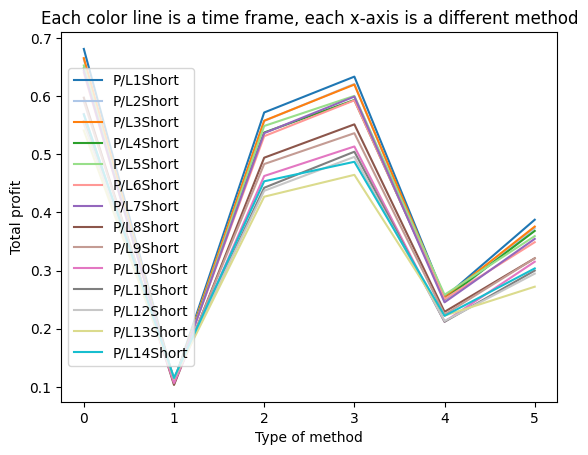

In [6]:
import numpy as np

colors = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan']
colors = plt.cm.tab20(np.linspace(0, 1, 15))

i = 0
# Plot each array with a different color
for k, v in totalProfLongList.items():

    t1 = sum(v)
    t2 = sum(totalProfLongListWithLowOpenLowDelata[k])
    t3 = sum(totalProfLongListWithHighOpenLowDelata[k])
    t4 = sum(totalProfLongListWithHighVolume[k])
    t5 = sum(totalProfLongListWithLowOpenLowDelata_filter_big_moves[k])
    t6 = sum(totalProfLongListWithLowOpenLowDelata_filter_most_moves[k])    
    data = [t1, t2, t3, t4, t5, t6]
    plt.plot(data, color=colors[i], label=k)
    i += 1

# Customize the plot
plt.xlabel('Type of method')
plt.ylabel('Total profit')
plt.title('Each color line is a time frame, each x-axis is a different method')
plt.legend()

# Show the plot
plt.show()